模拟数据集中的动作,就是传统的深度学习而已

In [ ]:
import torch


#封装数据集
class Dataset(torch.utils.data.Dataset):

    def __init__(self):
        import numpy as np
        data = np.loadtxt('discrete_dataset.txt')
        self.state = torch.FloatTensor(data[:, :4])
        self.action = torch.LongTensor(data[:, -1])

    def __len__(self):
        return len(self.state)

    def __getitem__(self, i):
        return self.state[i], self.action[i]


dataset = Dataset()

len(dataset), dataset[0]

(20000, (tensor([-0.0028,  0.0180, -0.0188, -0.0368]), tensor(0)))

In [2]:
#数据加载器
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=8,
                                     shuffle=True,
                                     drop_last=True)

len(loader), next(iter(loader))

(2500,
 [tensor([[ 0.1468,  0.0448, -0.0049, -0.0049],
          [ 0.0703, -0.0287,  0.0030,  0.1203],
          [-0.0451, -0.0434,  0.0447,  0.0019],
          [ 0.0695, -0.0102, -0.0017,  0.0970],
          [-0.0305,  0.0380, -0.0085,  0.0139],
          [ 0.0716,  0.0489,  0.0074,  0.0025],
          [ 0.0526,  0.0408,  0.0051,  0.0229],
          [ 0.0548,  0.1625,  0.0418, -0.2328]]),
  tensor([0, 1, 0, 1, 0, 1, 0, 1])])

In [3]:
#定义模型
model = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

model(torch.randn(2, 4)).shape

torch.Size([2, 2])

In [4]:
#训练
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(10):
        for i, (state, action) in enumerate(loader):
            out = model(state)

            loss = loss_fn(out, action)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 1 == 0:
            out = out.argmax(dim=1)
            acc = (out == action).sum().item() / len(action)
            print(epoch, loss.item(), acc)


train()

0 0.12874189019203186 1.0
1 0.2349461019039154 1.0
2 0.2650997042655945 0.875
3 0.1150398775935173 1.0
4 0.1450096070766449 1.0
5 0.280818372964859 0.875
6 0.06617259979248047 1.0
7 0.13647928833961487 0.875
8 0.08306241035461426 1.0
9 0.10768861323595047 1.0


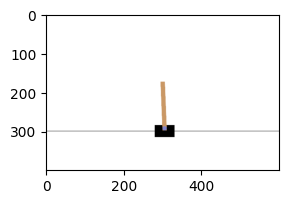

In [5]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [7]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
        if random.random() < 0.1:
            action = env.action_space.sample()

        state, reward, over = env.step(action)
        reward_sum += reward

        if show:
            display.clear_output(wait=True)
            env.show()

    return reward_sum


#测试
sum([play() for _ in range(20)]) / 20

200.0

In [ ]:
play(True)